## 数据准备

### 数据探索

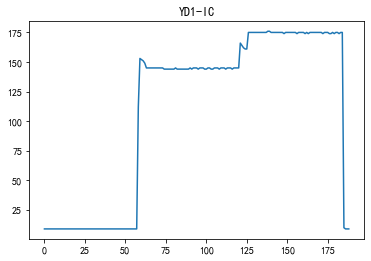

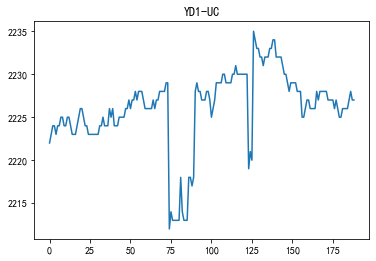

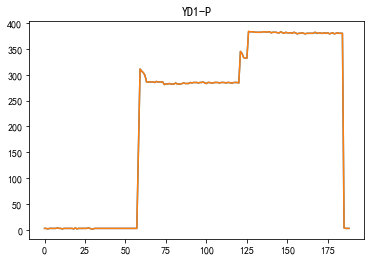

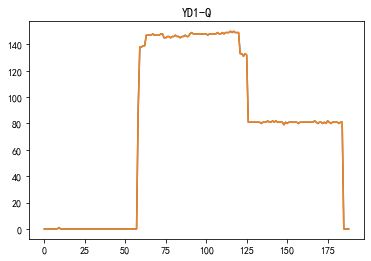

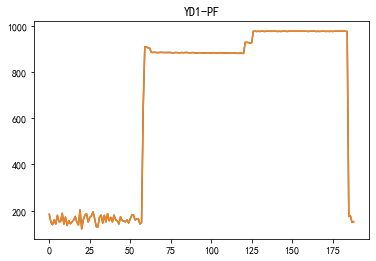

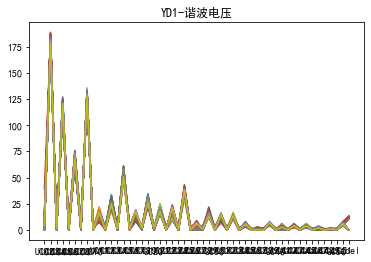

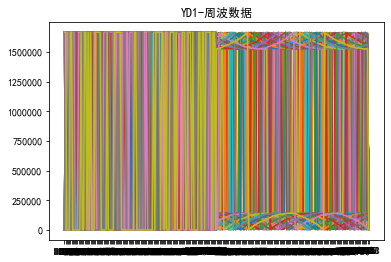

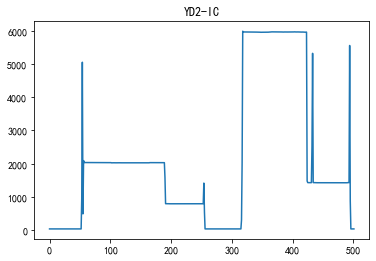

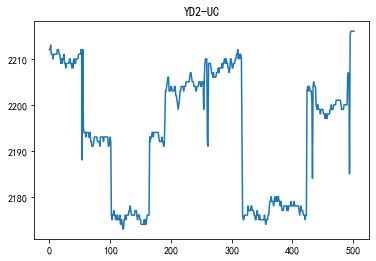

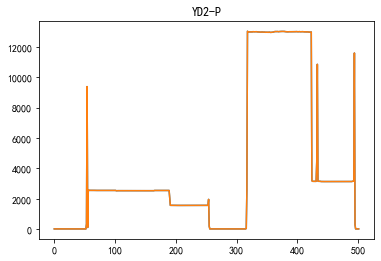

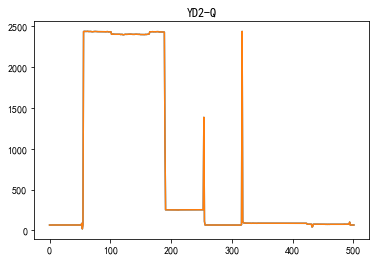

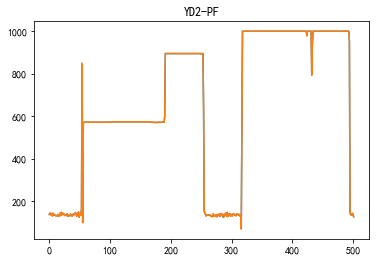

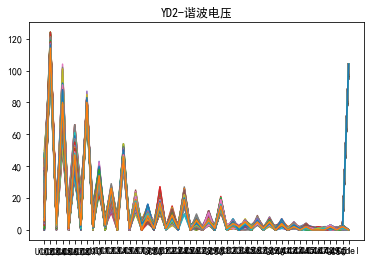

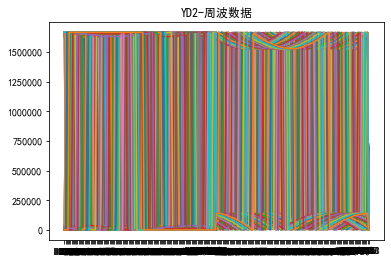

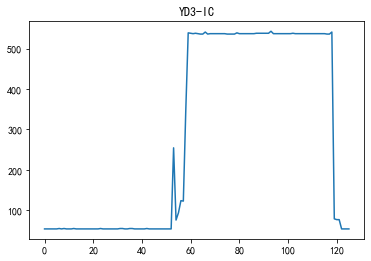

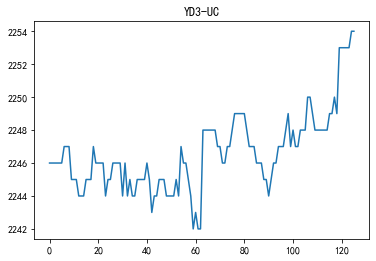

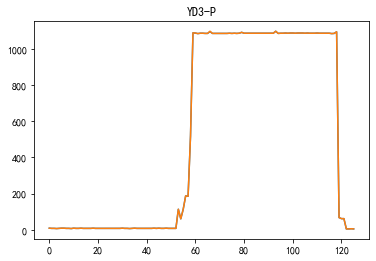

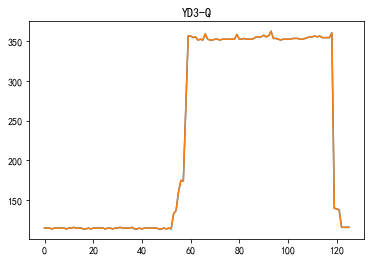

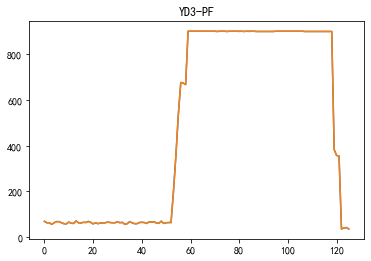

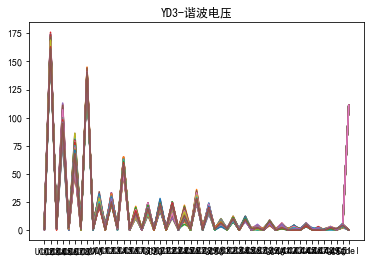

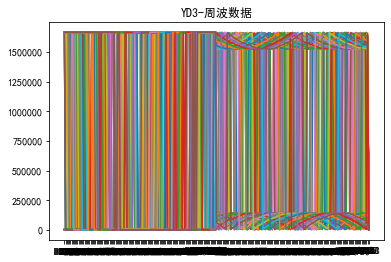

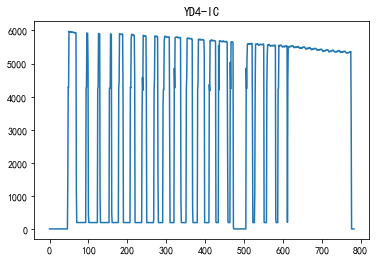

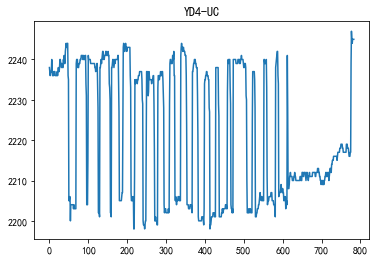

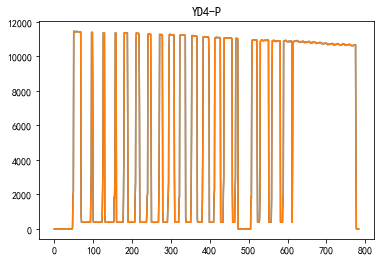

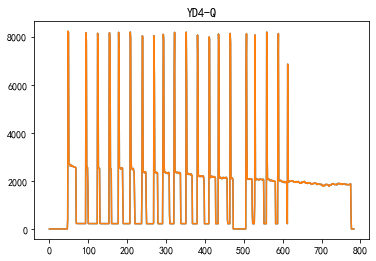

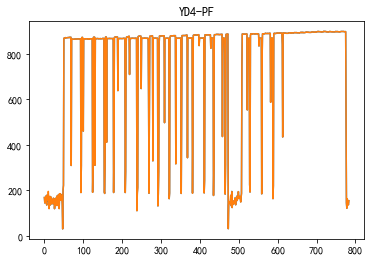

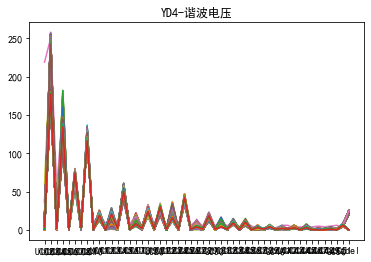

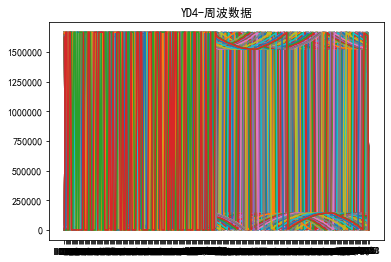

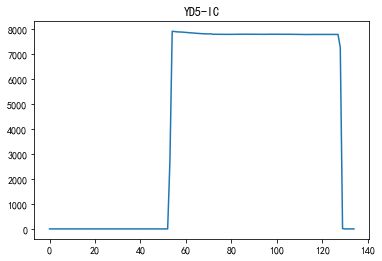

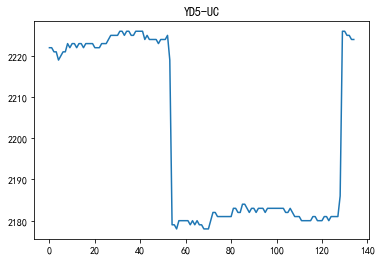

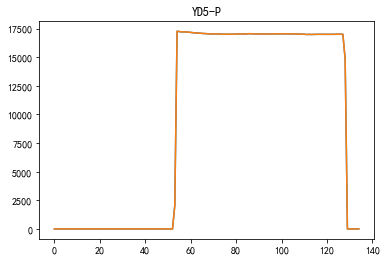

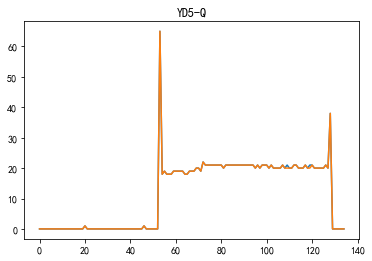

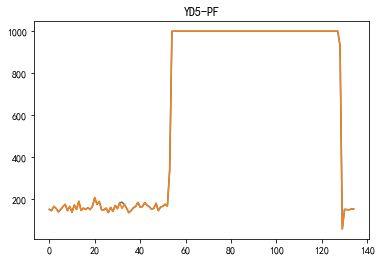

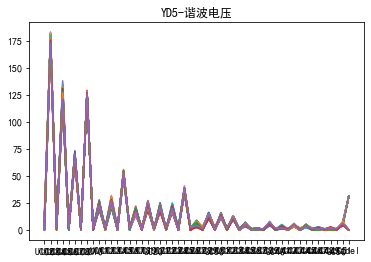

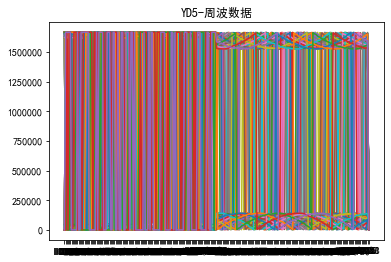

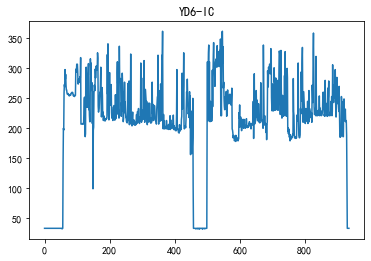

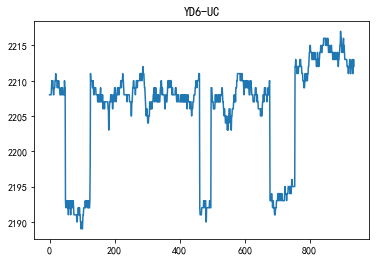

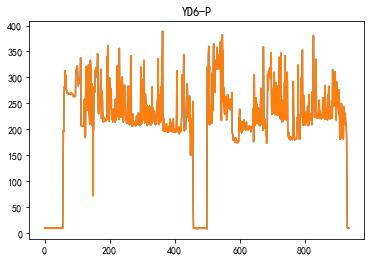

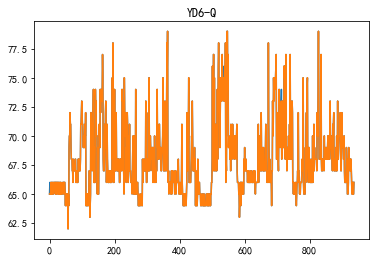

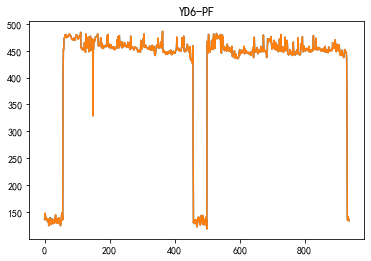

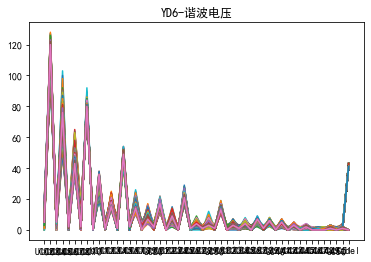

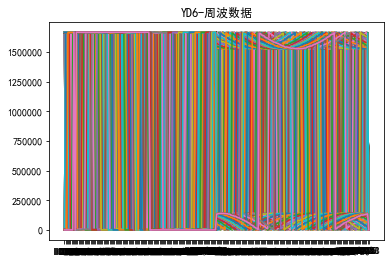

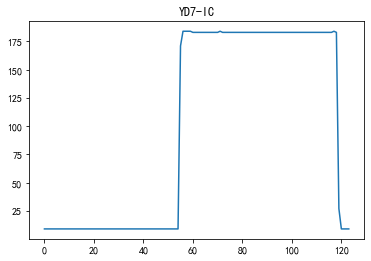

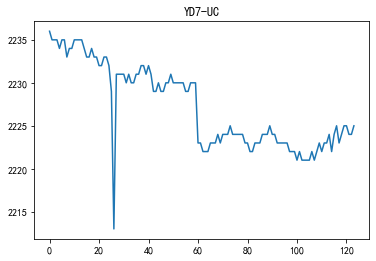

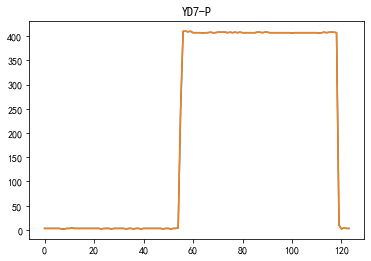

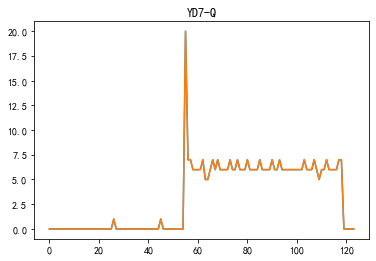

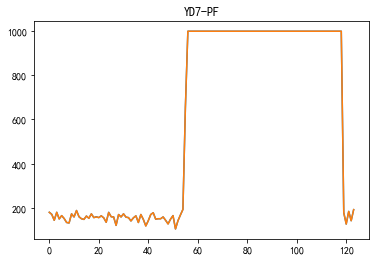

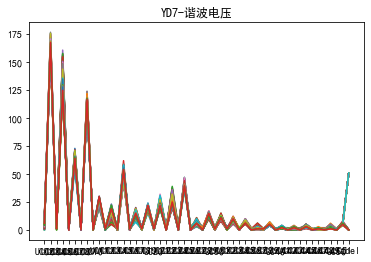

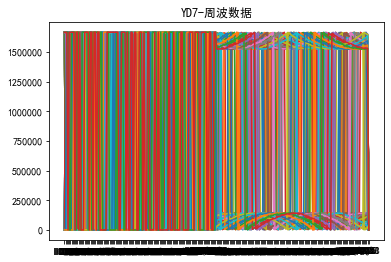

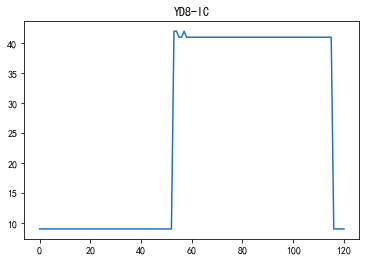

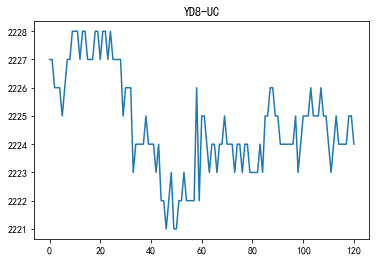

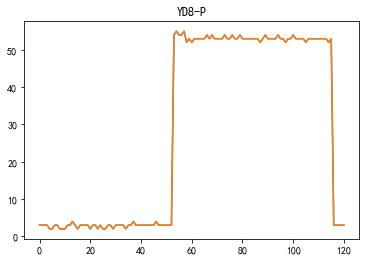

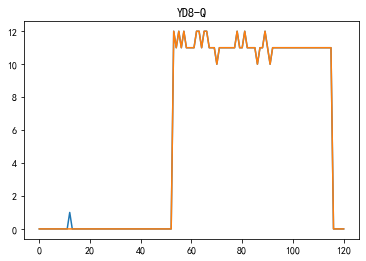

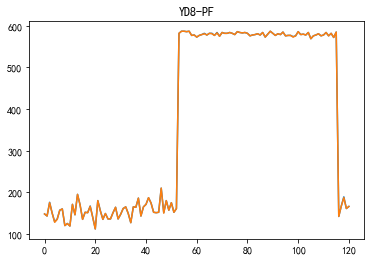

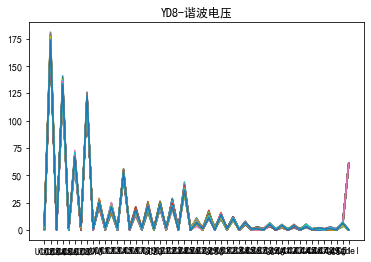

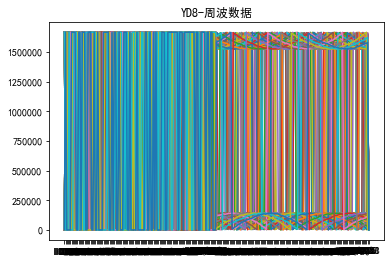

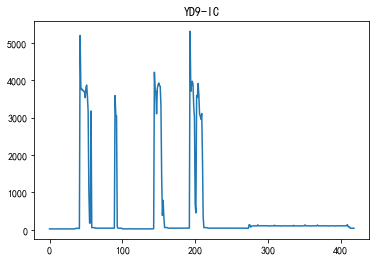

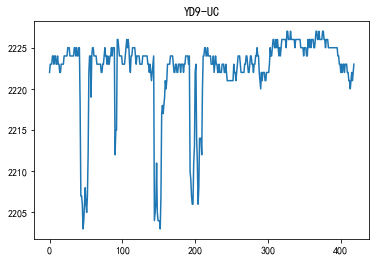

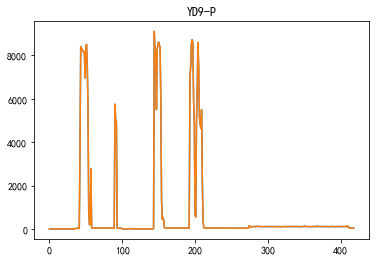

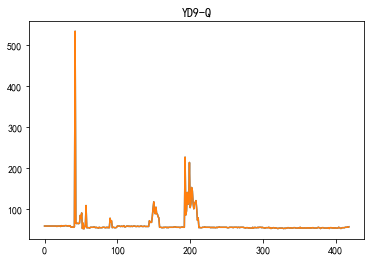

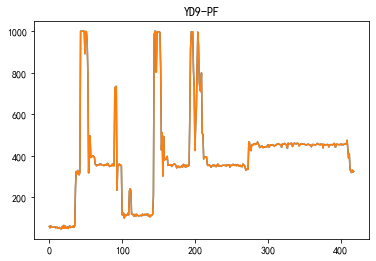

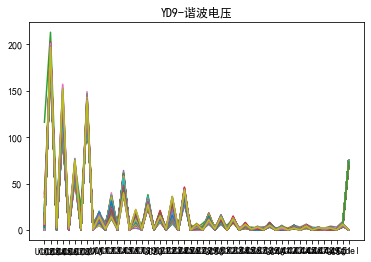

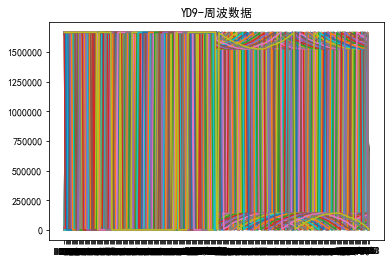

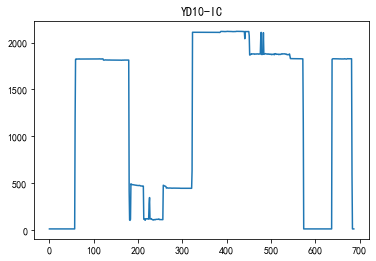

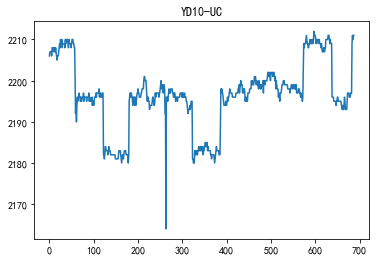

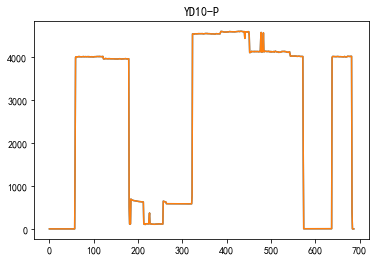

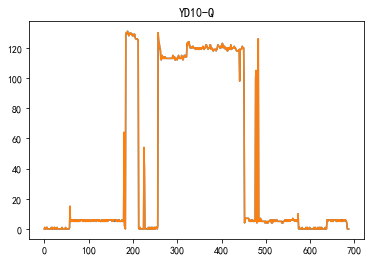

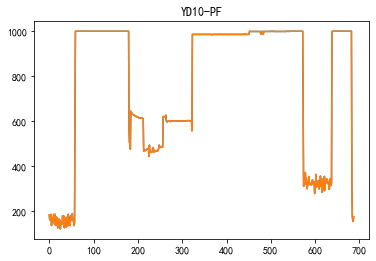

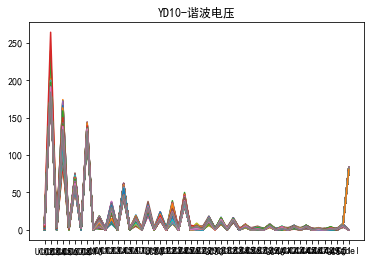

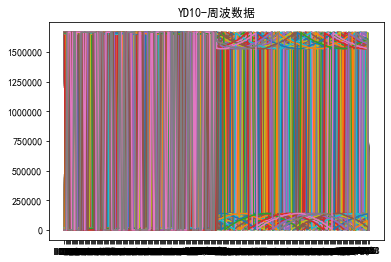

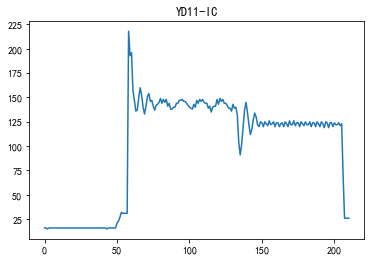

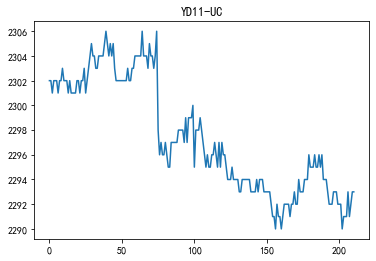

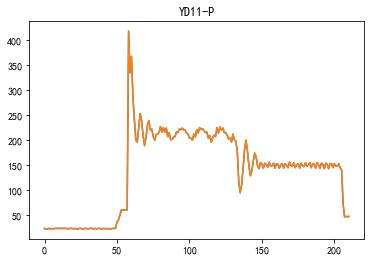

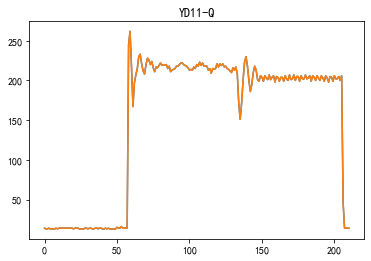

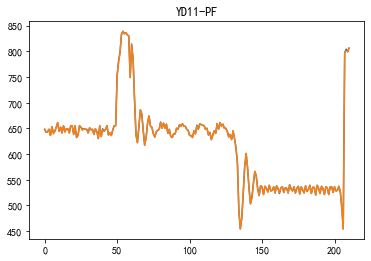

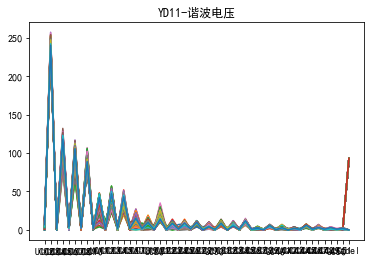

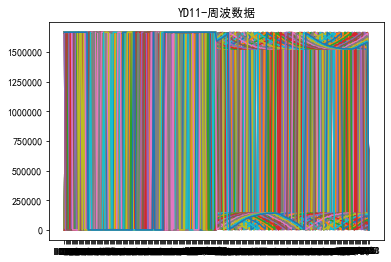

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 获取当前工作目录
current_dir = os.getcwd()
# 定义相对路径
relative_path = os.path.join(current_dir, '../data/附件1')
# 列出文件
filename = os.listdir(relative_path)
n_filename = len(filename)
# 确保 ../img/ 目录存在，不存在则创建
img_dir = os.path.join(current_dir, '../img')
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# 给设备数据添加操作信息，画出各特征轨迹图并保存
def fun(a):
    save_name = ['YD1','YD2','YD3','YD4','YD5','YD6','YD7','YD8','YD9','YD10','YD11']
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号   
    for i in range(a):
        Sb = pd.read_excel("../data/附件1/" + filename[i],'设备数据',index_col = None)
        Cz = pd.read_excel("../data/附件1/" + filename[i],'操作记录',index_col = 0)
        Xb = pd.read_excel("../data/附件1/" + filename[i],'谐波数据',index_col = None)
        Zb = pd.read_excel("../data/附件1/" + filename[i],'周波数据',index_col = None)
        # 电流轨迹图
        plt.plot(Sb['IC'])
        plt.title(save_name[i]+'-IC')
        plt.savefig(f"../img/{save_name[i]}-IC.png")  # 保存图表到指定目录
        plt.show()
        # 电压轨迹图
        plt.plot(Sb['UC'])
        plt.title(save_name[i] + '-UC')
        plt.savefig(f"../img/{save_name[i]}-UC.png")
        plt.show()
        # 有功功率和总有功功率
        plt.plot(Sb[['PC','P']])
        plt.title(save_name[i] + '-P')
        plt.savefig(f"../img/{save_name[i]}-P.png")
        plt.show()
        # 无功功率和总无功功率
        plt.plot(Sb[['QC','Q']])
        plt.title(save_name[i] + '-Q')
        plt.savefig(f"../img/{save_name[i]}-Q.png")
        plt.show()
        # 功率因数和总功率因数
        plt.plot(Sb[['PFC','PF']])
        plt.title(save_name[i] + '-PF')
        plt.savefig(f"../img/{save_name[i]}-PF.png")
        plt.show()
        # 谐波电压
        plt.plot(Xb.loc[:,'UC02':].T)
        plt.title(save_name[i] + '-谐波电压')
        plt.savefig(f"../img/{save_name[i]}-谐波电压.png")
        plt.show()
        # 周波数据
        plt.plot(Zb.loc[:,'IC001':].T)
        plt.title(save_name[i] + '-周波数据')
        plt.savefig(f"../img/{save_name[i]}-周波数据.png")
        plt.show()

fun(n_filename)

### 缺失值处理

In [5]:
# -*- coding: utf-8 -*-
import glob
import pandas as pd
import math
import os

# 将.xlsx文件转化为.csv文件
def file_transform(xls):
    print('共发现%s个xlsx文件' % len(glob.glob(xls)))
    print('正在处理............')
    for file in glob.glob(xls):  # 循环读取同文件夹下的xls文件
        combine1 = pd.read_excel(file, index_col=0, sheet_name=None)
        for key in combine1:
            combine1[key].to_csv('../tmp/'+file[8:-5] + key + '.csv', encoding='utf-8')
    print('处理完成')

xls_list = ['../data/附件1/*.xlsx', '../data/附件2/*.xlsx']
file_transform(xls_list[0])  # 处理训练数据
file_transform(xls_list[1])  # 处理测试数据

# 对每个单设备数据中较大缺失时间点数据进行删除处理，较小缺失时间段值进行前值替补
def missing_data(evi):
    print('共发现%s个CSV文件' % len(glob.glob(evi)))
    for j in glob.glob(evi):
        fr = pd.read_csv(j, header=0, encoding='gbk')
        fr['time'] = pd.to_datetime(fr['time'])
        helper = pd.DataFrame({'time': pd.date_range(fr['time'].min(), fr['time'].max(), freq='S')})
        fr = pd.merge(fr, helper, on='time', how='outer').sort_values('time')
        fr = fr.reset_index(drop=True)

        frame = pd.DataFrame()
        for g in range(0, len(list(fr['time'])) - 1):
            if math.isnan(fr.iloc[:, 1][g + 1]) and math.isnan(fr.iloc[:, 1][g]):
                continue
            else:
                scop = pd.Series(fr.loc[g])
                frame = pd.concat([frame, scop], axis=1)
        frame = pd.DataFrame(frame.values.T, index=frame.columns, columns=frame.index)
        frames = frame.fillna(method='ffill')
        frames.to_csv(j[:-4] + '1.csv', index=False, encoding='utf-8')
    print('处理完成')

evi_list = ['../tmp/附件1/*数据.csv', '../tmp/附件2/*数据.csv']
missing_data(evi_list[0])  # 处理训练数据
missing_data(evi_list[1])  # 处理测试数据


共发现11个xlsx文件
正在处理............
处理完成
共发现2个xlsx文件
正在处理............
处理完成
共发现33个CSV文件
处理完成
共发现6个CSV文件
处理完成


## 特征工程

In [6]:
import glob
import pandas as pd
from sklearn.cluster import KMeans
import os

# 合并11个设备数据及处理合并中重复的数据
def combined_equipment(csv_name):
    # 合并
    print('共发现%s个CSV文件' % len(glob.glob(csv_name)))
    print('正在处理............')
    for i in glob.glob(csv_name):  # 循环读取同文件夹下的csv文件
        fr = open(i, 'rb').read()
        file_path = os.path.split(i)
        with open(file_path[0] + '/device_combine.csv', 'ab') as f:  # 将结果保存为result.csv
            f.write(fr)
    print('合并完毕！')
    # 去重
    df = pd.read_csv(file_path[0] + '/device_combine.csv', header=None, encoding='utf-8')
    datalist = df.drop_duplicates()
    datalist.to_csv(file_path[0] + '/device_combine.csv', index=False, header=0)
    print('去重完成')

csv_list = ['../tmp/附件1/*设备数据1.csv', '../tmp/附件2/*设备数据1.csv']
combined_equipment(csv_list[0])  # 处理训练数据
combined_equipment(csv_list[1])  # 处理测试数据


共发现11个CSV文件
正在处理............
合并完毕！
去重完成
共发现2个CSV文件
正在处理............
合并完毕！
去重完成


In [7]:
# 求取周波数据中电流的波峰和波谷作为特征参数
def cycle(cycle_file):
    for file in glob.glob(cycle_file):
        cycle_YD = pd.read_csv(file, header=0, encoding='utf-8')
        cycle_YD1 = cycle_YD.iloc[:, 0:128]
        models = []
        for types in range(0, len(cycle_YD1)):
            model = KMeans(n_clusters=2, random_state=10)  # 分类n_clusters
            model.fit(pd.DataFrame(cycle_YD1.iloc[types, 1:]))  # 除时间以外的所有列
            models.append(model)

        # 相同状态间平稳求均值
        mean = pd.DataFrame()
        for model in models:
            r = pd.DataFrame(model.cluster_centers_, )  # 找出聚类中心
            r = r.sort_values(axis=0, ascending=True, by=[0])
            mean = pd.concat([mean, r.reset_index(drop=True)], axis=1)
            # b = int(files[56:-9])
        mean = pd.DataFrame(mean.values.T, index=mean.columns, columns=mean.index)
        mean.columns = ['波谷', '波峰']
        mean.index = list(cycle_YD['time'])
        mean.to_csv(file[:-9] + '波谷波峰.csv', index=False, encoding='gbk')

cycle_file = ['../tmp/附件1/*周波数据1.csv', '../tmp/附件2/*周波数据1.csv']
cycle(cycle_file[0])  # 处理训练数据
cycle(cycle_file[1])  # 处理测试数据

# 合并周波的波峰波谷文件
def merge_cycle(cycles_file):
    means = pd.DataFrame()
    for files in glob.glob(cycles_file):
        mean0 = pd.read_csv(files, header=0, encoding='gbk')
        means = pd.concat([means, mean0])
    file_path = os.path.split(glob.glob(cycles_file)[0])
    means.to_csv(file_path[0] + '/zuhe.csv', index=False, encoding='gbk')
    print('合并完成')

cycles_file = ['../tmp/附件1/*波谷波峰.csv', '../tmp/附件2/*波谷波峰.csv']
merge_cycle(cycles_file[0])  # 训练数据
merge_cycle(cycles_file[1])  # 测试数据

合并完成
合并完成


## 模型训练

In [8]:
import glob
import pandas as pd
from sklearn import neighbors
import pickle
import os

# 模型训练
def model(test_files, test_devices):
    # 训练集
    zuhe = pd.read_csv('../tmp/附件1/zuhe.csv', header=0, encoding='gbk')
    device_combine = pd.read_csv('../tmp/附件1/device_combine.csv', header=0, encoding='gbk')
    train = pd.concat([zuhe, device_combine], axis=1)
    train.index = train['time'].tolist()  # 把‘time’列设为索引
    train = train.drop(['PC', 'QC', 'PFC', 'time'], axis=1)
    train.to_csv('../tmp/' + 'train.csv', index=False, encoding='gbk')
    # 测试集
    for test_file, test_device in zip(test_files, test_devices):
        test_bofeng = pd.read_csv(test_file, header=0, encoding='gbk')
        test_devi = pd.read_csv(test_device, header=0, encoding='gbk')
        test = pd.concat([test_bofeng, test_devi], axis=1)
        test.index = test['time'].tolist()  # 把‘time’列设为索引
        test = test.drop(['PC', 'QC', 'PFC', 'time'], axis=1)

        # K近邻
        clf = neighbors.KNeighborsClassifier(n_neighbors=6, algorithm='auto')
        clf.fit(train.drop(['label'], axis=1), train['label'])
        predicted = clf.predict(test.drop(['label'], axis=1))
        predicted = pd.DataFrame(predicted)
        file_path = os.path.split(test_file)[1]
        test.to_csv('../tmp/' + file_path[:3] + 'test.csv', encoding='gbk')
        predicted.to_csv('../tmp/' + file_path[:3] + 'predicted.csv', index=False, encoding='gbk')
        with open('../tmp/' + file_path[:3] + "model.pkl", "ab") as pickle_file:
            pickle.dump(clf, pickle_file)
        print(clf)

model(glob.glob('../tmp/附件2/*波谷波峰.csv'),glob.glob('../tmp/附件2/*设备数据1.csv'))


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')


## 性能度量

模型分类准确度： 0.5893416927899686
模型评估报告：
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        67
        81.0       0.52      0.80      0.63        70
        82.0       1.00      0.01      0.03        68
        83.0       0.82      0.56      0.67       114
        84.0       0.00      1.00      0.00         0

    accuracy                           0.59       319
   macro avg       0.67      0.68      0.47       319
weighted avg       0.83      0.59      0.59       319



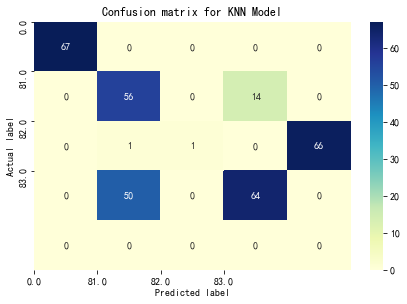

计算auc： 0.7607105538140021


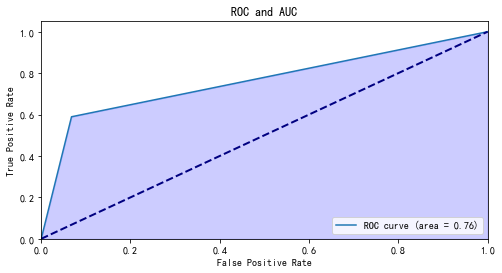

模型分类准确度： 0.8926829268292683
模型评估报告：
               precision    recall  f1-score   support

         0.0       1.00      0.86      0.92        64
        11.0       0.00      1.00      0.00         0
        22.0       0.00      1.00      0.00         0
        61.0       0.00      1.00      0.00         0
        91.0       0.92      0.87      0.89        77
        92.0       0.33      0.40      0.36         5
        93.0       0.89      1.00      0.94        59

    accuracy                           0.89       205
   macro avg       0.45      0.88      0.45       205
weighted avg       0.92      0.89      0.90       205



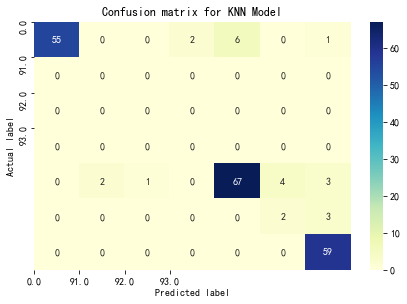

计算auc： 0.932520325203252


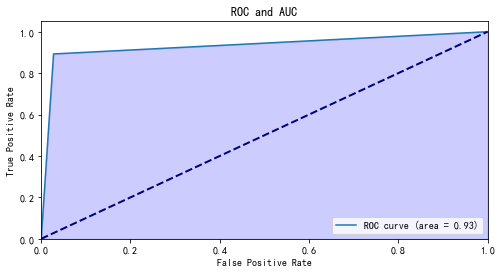

In [9]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.metrics import accuracy_score  # 导入accuracy_score
import pickle
import os

# 模型评估
def model_evaluation(model_file, test_csv, predicted_csv):
    train = pd.read_csv('../tmp/' + 'train.csv', encoding='gbk')
    for clf, test, predicted in zip(model_file, test_csv, predicted_csv):
        with open(clf, "rb") as pickle_file:
            clf = pickle.load(pickle_file)
        # 读取测试集和预测结果
        test = pd.read_csv(test, header=0, encoding='gbk')
        predicted = pd.read_csv(predicted, header=0, encoding='gbk')
        # 处理列名
        test.columns = ['time', '波谷', '波峰', 'IC', 'UC', 'P', 'Q', 'PF', 'label']
        # 计算分类准确度
        X_test = test.drop(['label', 'time'], axis=1)
        y_test = test['label']
        print('模型分类准确度：', accuracy_score(y_test, predicted))
        # 打印评估报告
        print('模型评估报告：\n', metrics.classification_report(y_test, predicted, zero_division=1))

        # 混淆矩阵
        confusion_matrix0 = metrics.confusion_matrix(y_test, predicted)
        confusion_matrix = pd.DataFrame(confusion_matrix0)
        class_names = list(set(y_test))
        # 绘制混淆矩阵
        tick_marks = range(len(class_names))
        sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu', fmt='g')
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        plt.tight_layout()
        plt.title('Confusion matrix for KNN Model', y=1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()

        # 计算AUC
        y_binarize = label_binarize(y_test, classes=class_names)
        predicted_binarize = label_binarize(predicted, classes=class_names)
        fpr, tpr, thresholds = metrics.roc_curve(y_binarize.ravel(), predicted_binarize.ravel())
        auc = metrics.auc(fpr, tpr)
        print('计算auc：', auc)

        # 绘制ROC曲线
        plt.figure(figsize=(8, 4))
        lw = 2
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.fill_between(fpr, tpr, alpha=0.2, color='b')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC and AUC')
        plt.legend(loc="lower right")
        plt.show()

model_evaluation(glob.glob('../tmp/*model.pkl'), glob.glob('../tmp/*test.csv'), glob.glob('../tmp/*predicted.csv'))


In [10]:
# 计算实时用电量并输出状态表
def cw(test_csv, predicted_csv, test_devices):
    for test, predicted, test_device in zip(test_csv, predicted_csv, test_devices):
        # 划分预测出的时刻表
        test = pd.read_csv(test, header=0, encoding='gbk')
        test.columns = ['time', '波谷', '波峰', 'IC', 'UC', 'P', 'Q', 'PF', 'label']
        test['time'] = pd.to_datetime(test['time'])
        test.index = test['time']
        predicteds = pd.read_csv(predicted, header=0, encoding='gbk')
        predicteds.columns = ['label']
        indexes = []
        class_names = list(set(test['label']))
        for j in class_names:
            index = list(predicteds.index[predicteds['label'] == j])
            indexes.append(index)

        # 取出首位序号及时间点
        from itertools import groupby  # 连续数字
        dif_indexs = []
        time_indexes = []
        info_lists = pd.DataFrame()
        for y, z in zip(indexes, class_names):
            dif_index = []
            fun = lambda x: x[1] - x[0]
            for k, g in groupby(enumerate(y), fun):
                dif_list = [j for i, j in g]  # 连续数字的列表
                if len(dif_list) > 1:
                    scop = min(dif_list)  # 选取连续数字范围中的第一个
                else:
                    scop = dif_list[0]
                dif_index.append(scop)
            time_index = list(test.iloc[dif_index, :].index)
            time_indexes.append(time_index)
            info_list = pd.DataFrame({'时间': time_index, 'model_设备状态': [z] * len(time_index)})
            dif_indexs.append(dif_index)
            info_lists = pd.concat([info_lists, info_list])
        # 计算实时用电量并保存状态表
        test_devi = pd.read_csv(test_device, header=0, encoding='gbk')
        test_devi['time'] = pd.to_datetime(test_devi['time'])
        test_devi['实时用电量'] = test_devi['P'] * 100 / 3600
        info_lists = info_lists.merge(test_devi[['time', '实时用电量']], how='inner', left_on='时间', right_on='time')
        info_lists = info_lists.sort_values(by=['时间'], ascending=True)
        info_lists = info_lists.drop(['time'], axis=1)
        file_path = os.path.split(test_device)[1]
        info_lists.to_csv('../tmp/' + file_path[:3] + '状态表.csv', index=False, encoding='gbk')
        print(info_lists)

cw(glob.glob('../tmp/*test.csv'),glob.glob('../tmp/*predicted.csv'),glob.glob('../tmp/附件2/*设备数据1.csv'))


                    时间  model_设备状态       实时用电量
0  2018-01-16 15:48:37         0.0    0.083333
28 2018-01-16 15:49:38        82.0    0.888889
2  2018-01-16 15:54:19        81.0   79.694444
29 2018-01-16 15:54:20        83.0  114.527778
3  2018-01-16 15:58:17        81.0  113.527778
30 2018-01-16 15:58:21        83.0  113.611111
4  2018-01-16 15:58:29        81.0  113.500000
31 2018-01-16 15:58:30        83.0  113.555556
5  2018-01-16 15:58:33        81.0  113.611111
32 2018-01-16 15:58:34        83.0  113.583333
6  2018-01-16 15:58:35        81.0  113.527778
33 2018-01-16 15:58:36        83.0  113.527778
7  2018-01-16 15:58:39        81.0  113.472222
34 2018-01-16 15:58:40        83.0  113.500000
8  2018-01-16 15:58:41        81.0  113.416667
35 2018-01-16 15:58:42        83.0  113.444444
9  2018-01-16 15:58:43        81.0  113.500000
36 2018-01-16 15:58:44        83.0  113.500000
10 2018-01-16 15:58:45        81.0  113.444444
37 2018-01-16 15:58:49        83.0  113.500000
11 2018-01-16